In [1]:
import quandl
from sklearn.model_selection import train_test_split
import datetime 
import numpy as np,pandas as pd
import sklearn
import sklearn.decomposition as decomposition
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix 
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from sklearn import preprocessing

In [2]:
#load data
df = pd.read_csv('input/US.csv',index_col=0,parse_dates=True)
df = df['2001':]
df_spx = pd.read_csv('input/SPX.csv',index_col=0,parse_dates=True)
df_libor = pd.read_csv('input/libor.csv',index_col=0,parse_dates=True)
df_libor[df_libor=='.']=np.nan
df_libor = df_libor.astype(float).dropna()



In [3]:
#Modeling:
def resample_month(df):
    return df.resample('BMS',label='left').first()
def simulation(df,signal):
    rt = pd.Series(index =df.index)
    equity = 1
    balance_list = list(signal.index)
    position = 0
    for index,row in pd.DataFrame(df).iterrows(): #assume df is a serie/
        current = 0 if pd.isna(row[0]) else row[0]
        if balance_list == []:
            break
        if index>=balance_list[0]:
            position = signal[balance_list.pop(0)]
    #         print(balance_list[0],len(balance_list))
        if position == 0:
            rt[index]=equity
            continue
        equity = equity  * (1+current* position)
        rt[index]=equity
    return rt
#Performance
Rf = .0151
def create_sharpe_ratio(returns, periods=252):
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).

    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    
    return np.sqrt(periods) * (np.mean(returns)-Rf/periods) / np.std(returns)


def create_drawdowns(pnl):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])/hwm[t]
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

def create_sortina(equity,periods = 252):

    '''
    sortino is an adjusted ratio which only takes the 
    standard deviation of negative returns into account
    '''
    ret = equity.pct_change().dropna()
    adj_ret = ret-Rf/252
    avg_ret = np.mean(ret)

    # Take all negative returns.
    neg_ret = [a ** 2 for a in adj_ret if a < 0]
    # Sum it.
    neg_ret_sum = np.sum(neg_ret)
    # And calculate downside risk as second order lower partial moment.
    down_risk = np.sqrt(periods*neg_ret_sum / len(ret))

    if down_risk > 0.0001:
        sortino = avg_ret / down_risk
    else:
        sortino = 0

    return sortino

In [4]:
# Insert 30-year treasury, sp500 and libor into the grand dataframe.
grand_df = pd.DataFrame()
grand_df['US'] = resample_month(df)['Last'].pct_change()
grand_df['SPX'] = resample_month(df_spx)['Last']
grand_df['LIBOR'] = resample_month(df_libor)['USD3MTD156N']
# y is the treasury price in the following month.
grand_df['y'] = 1
grand_df['return']=grand_df['US'].shift(-1)
grand_df.loc[grand_df['return']<0,'y']=-1
grand_df.dropna(inplace=True)
#grand_df[['US','SPX','LIBOR']]=preprocessing.scale(grand_df[['US','SPX','LIBOR']])


In [5]:
grand_df_train = grand_df[:'2010']
grand_df_test = grand_df['2011':]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(grand_df_train[['US','SPX','LIBOR']], 
                     grand_df_train['y'], test_size=.5,shuffle=False)


In [7]:
# Prepare 4 Models in the tuple of the format (model name, model)
models = [("LR", sklearn.linear_model.LogisticRegression()),
("SVR", sklearn.svm.SVR(
C=1000000.0, cache_size=200, coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
max_iter=-1,
  shrinking=True, tol=0.001, verbose=False)),
("SVC", sklearn.svm.SVC(
C=1000000.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
),
("RF", RandomForestClassifier(
  n_estimators=1000, criterion='gini',
  max_depth=None, min_samples_split=2,
min_samples_leaf=1, max_features='auto',
            bootstrap=True, oob_score=False, n_jobs=1,
            random_state=None, verbose=0)
)]

for m in models:
    # Train each of the models on the training set
    m[1].fit(X_train, y_train)
    pred = m[1].predict(X_test)
    pred_train = m[1].predict(X_train)
    # Output the hit-rate and the confusion matrix for each model
    print("%s:\n%0.3f" % (m[0], m[1].score(X_train, y_train))) 
#     print("%s\n" % confusion_matrix(pred, y_test))

LR:
0.525
SVR:
0.163
SVC:
0.763
RF:
1.000


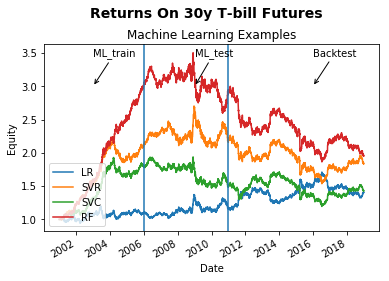

In [8]:
fig = plt.figure()
fig.suptitle('Returns On 30y T-bill Futures', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('Machine Learning Examples')

list_results = list()
for i in range(len(models)):
    signal = models[i][1].predict(grand_df.iloc[:,:3]) #Use the model to find signals
    signal[signal>0]=1
    signal[signal<0]=-1
    signal = pd.Series(signal,index=grand_df.index)
    #simulation function performs backtest
    list_results.append(simulation(df.pct_change(),signal))
    list_results[i].plot()
plt.axvline(x='2011')
plt.axvline(x=X_test.index[0])
plt.legend(list(map(lambda x: x[0],models)),loc=3);
plt.ylabel('Equity');
x = datetime.datetime(2003,1,1)
y = datetime.datetime(2009,1,1)
z = datetime.datetime(2016,1,1)
ax.annotate('ML_train', (mdates.date2num(x), 3), xytext=(0, 30), 
            textcoords='offset points', arrowprops=dict(arrowstyle='->'));
ax.annotate('ML_test', (mdates.date2num(y), 3), xytext=(0, 30), 
            textcoords='offset points', arrowprops=dict(arrowstyle='->'));
ax.annotate('Backtest', (mdates.date2num(z), 3), xytext=(0, 30), 
            textcoords='offset points', arrowprops=dict(arrowstyle='->'));
plt.savefig('Returns')

In [9]:
for i in range(len(list_results)):
    equity = list_results[i]['2011':].dropna()
    sharpe = create_sharpe_ratio(equity.pct_change())
    sortina = create_sortina(equity)
    drawdown, max_dd, dd_duration = create_drawdowns(equity)
    print(f'----------------------------------------{models[i][0]}----------------------------------------')
    print(f'Sharpe: {sharpe:.4f} Sortina: {sortina:.4f} max drowdown: {max_dd:.4f} drowdown duration: {dd_duration}')

----------------------------------------LR----------------------------------------
Sharpe: 0.1280 Sortina: 0.0016 max drowdown: 0.2268 drowdown duration: 669.0
----------------------------------------SVR----------------------------------------
Sharpe: -0.3179 Sortina: -0.0009 max drowdown: 0.3218 drowdown duration: 1989.0
----------------------------------------SVC----------------------------------------
Sharpe: -0.1649 Sortina: -0.0001 max drowdown: 0.3020 drowdown duration: 1259.0
----------------------------------------RF----------------------------------------
Sharpe: -0.5878 Sortina: -0.0023 max drowdown: 0.3785 drowdown duration: 1989.0
